In [2]:
import numpy as np
import pandas as pd
import string

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])
sns.set_style('whitegrid')
# Alternate #
plt.style.use('fivethirtyeight')


%matplotlib inline

import os

import re
import nltk

from fuzzywuzzy import fuzz

import math

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors # implements unsupervised nearest neighbors learning. 


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


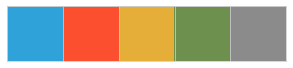

In [179]:
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]

sns.set_palette(five_thirty_eight)
sns.palplot(sns.color_palette())
plt.show()

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'genome_scores.csv',
 'genome_tags.csv',
 'link.csv',
 'movie.csv',
 'movielens-20m-dataset.zip',
 'rating.csv',
 'tag.csv',
 'Untitled.ipynb']

In [3]:
movie = pd.read_csv('movie.csv')
ratings = pd.read_csv('rating.csv')
genome_score = pd.read_csv('genome_scores.csv') # contains movieId, tagid and their relevance
genome = pd.read_csv("genome_tags.csv") # contains tags with their ids
tag = pd.read_csv('tag.csv') #

In [3]:
len(movie.movieId.unique())

27278

In [4]:
print('Movie Data Frame:', movie.shape)
print('Ratings Data Frame:', ratings.shape)
print('Genome Score Data Frame:', genome_score.shape)
print('Genome Data Frame:', genome.shape)
print('Tag Data Frame:', tag.shape)

print('--'*20)
print('\n')
print('Total movie titles in Movie dataset:',len(movie.movieId.unique()))
print('Total movie titles in Ratings dataset:',len(ratings.movieId.unique()))

Movie Data Frame: (27278, 3)
Ratings Data Frame: (20000263, 4)
Genome Score Data Frame: (11709768, 3)
Genome Data Frame: (1128, 2)
Tag Data Frame: (465564, 4)
----------------------------------------


Total movie titles in Movie dataset: 27278
Total movie titles in Ratings dataset: 26744


It seems that there are around 500 something movies that are not in our Ratings dataset. Let's find those. 

In [34]:
aa = list(avg_rating.movieId)
bb = list(movie.movieId)
cc = [w for w in bb if w not in aa]

In [36]:
movie[movie.movieId.isin(cc)]

,movieId,title,genres
8555,26018,Chase a Crooked Shadow (1958),Crime|Film-Noir|Mystery|Thriller
8933,26580,"Park Is Mine, The (1986)",Action|Drama|Thriller
9249,27249,"Trumpet of the Swan, The (2001)",Animation|Drama|Musical
9315,27396,"Gentleman's Game, A (2002)",Drama
9770,31797,White Banners (1938),Drama
...,...,...,...
26818,128886,Love at the Top (1974),Comedy|Drama
26872,129201,The Time Being (2012),Mystery
26933,129443,Thank You a Lot (2014),Drama
27004,129820,Spare Parts (2015),Children|Drama


In [4]:
# Pre-processing and merging

movie_rating = pd.merge(movie, ratings, on='movieId')

genome_scores = genome_score[genome_score['relevance']>0.5].merge(genome, on='tagId',how='left')

genome_scores = genome_scores.groupby(by='movieId')['tag'].apply(lambda x:', '.join(x)).reset_index()

df = pd.merge(movie, genome_scores, on='movieId', how='left')

df.rename(mapper = {'tag':'tags'}, axis=1, inplace=True)

tag.tag = tag.tag.astype(str)
tags  = tag.groupby(by='movieId')['tag'].apply(lambda x: ', '.join(x)).reset_index()

df = pd.merge(df, tags, on='movieId', how='left')

df['genres']= df['genres'].str.replace('|', ', ')

In [4]:
df.head()

,movieId,title,genres,tags,tag
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy","3d, action, adventure, affectionate, animal mo...","Watched, computer animation, Disney animated f..."
1,2,Jumanji (1995),"Adventure, Children, Fantasy","action, adapted from:book, adventure, animal m...","time travel, adapted from:book, board game, ch..."
2,3,Grumpier Old Men (1995),"Comedy, Romance","chase, comedy, crappy sequel, destiny, family,...","old people that is actually funny, sequel feve..."
3,4,Waiting to Exhale (1995),"Comedy, Drama, Romance","adultery, betrayal, chick flick, divorce, feel...","chick flick, revenge, characters, chick flick,..."
4,5,Father of the Bride Part II (1995),Comedy,"catastrophe, chase, comedy, crappy sequel, cul...","Diane Keaton, family, sequel, Steve Martin, we..."


## EDA

### Movie dataset

In [38]:
genre = movie.genres.str.replace('|', ',').str.split(',')

In [43]:
# for row in genre:
#     for g in row:
#         t.append(g)

genre_tokens = [g for row in genre for g in row]

In [46]:
items = nltk.FreqDist(genre_tokens)
items_s = sorted(list(items.items()), key= lambda kv: kv[1], reverse=True )

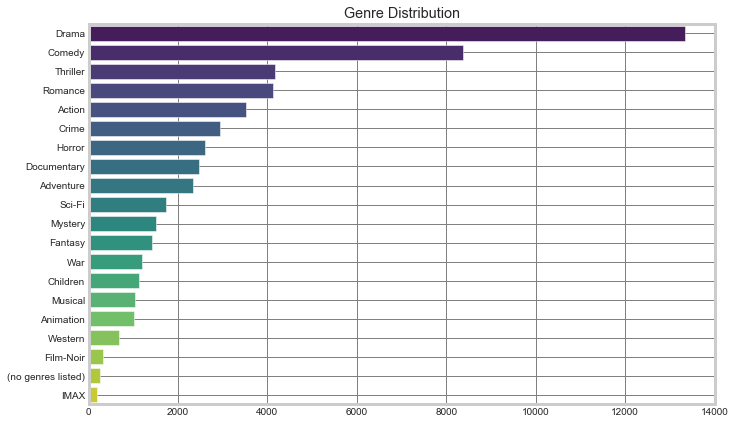

In [113]:
k,v = zip(*items_s)
f, ax = plt.subplots(figsize=(10,7))
sns.set_style('whitegrid')
sns.barplot(y=list(k), x=list(v), palette='viridis')
ax.set_title('Genre Distribution')

ax.grid(b=True, which='major', color='gray', linewidth=1.0)
ax.grid(b=True, which='minor', color='gray', linewidth=0.5)

#### Year
It appears that most tiltes have year of release in brackets. We can try to find which year had most releases. 

In [311]:
movie_year = movie[movie.title.apply(lambda x: len(re.findall(r'\(\d{4}\)',x)))>0].copy()

In [312]:
movie_year['year'] = movie_year.title.apply(lambda x: re.findall(r'\(\d{4}\)',x)[0])

In [313]:
movie_year.groupby('year')['movieId'].count().reset_index()

,year,movieId
0,(1891),1
1,(1893),1
2,(1894),2
3,(1895),2
4,(1896),2
...,...,...
113,(2011),1016
114,(2012),1022
115,(2013),1011
116,(2014),740


In [314]:
movie_year['year'] = movie_year['year'].apply(lambda x: re.sub(r'\(*\)*', '', x))

In [315]:
movie_year.year.unique()

array(['1995', '1994', '1996', '1976', '1992', '1988', '1967', '1993',
       '1964', '1977', '1965', '1982', '1985', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1959', '1968', '1980', '1975', '1986', '1948', '1943', '1950',
       '1946', '1987', '1997', '1974', '1956', '1958', '1949', '1972',
       '1998', '1933', '1952', '1951', '1957', '1961', '1954', '1934',
       '1944', '1963', '1942', '1941', '1953', '1939', '1947', '1945',
       '1938', '1935', '1936', '1926', '1932', '1979', '1971', '1978',
       '1966', '1962', '1983', '1984', '1931', '1922', '1999', '1927',
       '1929', '1930', '1928', '1925', '1914', '2000', '1919', '1923',
       '1920', '1918', '1921', '2001', '1924', '2002', '2003', '1915',
       '2004', '1916', '1917', '2005', '2006', '1902', '1903', '2007',
       '2008', '2009', '1912', '2010', '1913', '2011', '1898', '1899',
       '1894', '2012', '1909', '1910', '1901', '1893', '2013', '1896',
      

In [316]:
movie_year

,movieId,title,genres,first_num,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,2,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,3,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,4,1995
4,5,Father of the Bride Part II (1995),Comedy,5,1995
...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,1,2007
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,1,2002
27275,131258,The Pirates (2014),Adventure,1,2014
27276,131260,Rentun Ruusu (2001),(no genres listed),1,2001


In [317]:
movie_year = movie_year.groupby('year')['movieId'].count().reset_index().sort_values(by='movieId', ascending=False)
#movie_year.rename({'movieId': 'count'},axis=1, inplace=True)


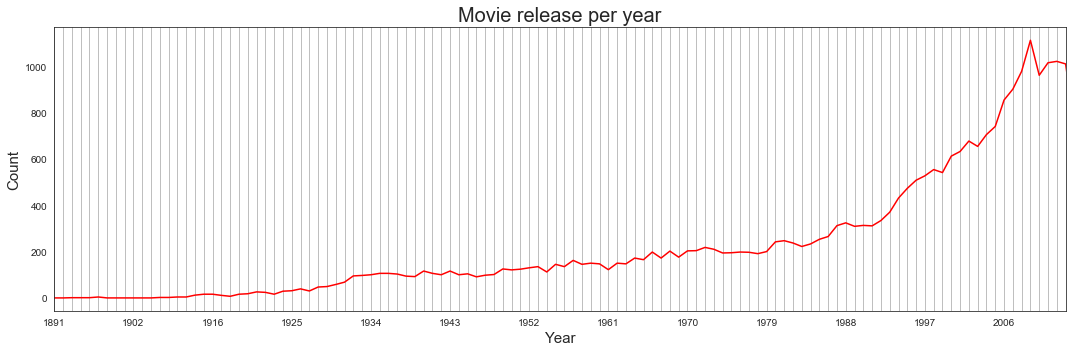

In [398]:
sns.set_style('white')
f , ax = plt.subplots(figsize=(15,5))
l = sns.lineplot(x='year', y='movieId', data=movie_year, color='red')
for ind, label in enumerate(l.get_xticklabels()):
    if ind % 9 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.grid(b=True, which='both', axis='x', color='grey', alpha=0.5,linewidth=1.0)
#ax.grid(b=False, which='minor', color='grey', linewidth=0.5)ax.set_ylabel('Count', size=15)
ax.set_xlabel('Year', size=15)
ax.set_ylabel('Count', size=15)
ax.set_title('Movie release per year',size=20)
ax.set_xlim('1891','2013')
plt.tight_layout()


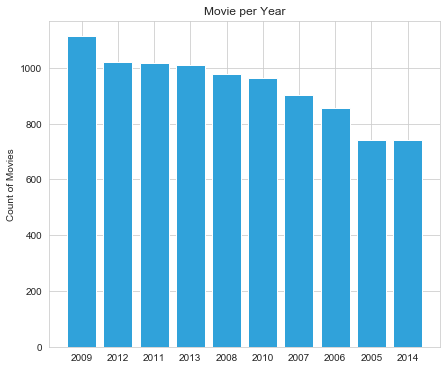

In [319]:
fig, ax = plt.subplots(figsize=(7,6))
plt.bar(x='year', height='movieId', data=movie_year[:10])
ax.set_title('Movie per Year');
ax.set_ylabel('Count of Movies');

It appears 2009 had most releases

In [462]:
del movie_year

### Rating dataset

In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
avg_rating = ratings.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()

In [7]:
avg_rating['count'].describe()

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: count, dtype: float64

In [6]:
avg_rating = avg_rating.merge(movie[['movieId', 'title']], on='movieId')
avg_rating.rename(mapper={'count':'num_rating', 'mean':'rating_mean'},axis=1, inplace=True)
avg_rating = avg_rating[['movieId', 'title', 'num_rating', 'rating_mean']]
avg_rating

,movieId,title,num_rating,rating_mean
0,1,Toy Story (1995),49695,3.921240
1,2,Jumanji (1995),22243,3.211977
2,3,Grumpier Old Men (1995),12735,3.151040
3,4,Waiting to Exhale (1995),2756,2.861393
4,5,Father of the Bride Part II (1995),12161,3.064592
...,...,...,...,...
26739,131254,Kein Bund für's Leben (2007),1,4.000000
26740,131256,"Feuer, Eis & Dosenbier (2002)",1,4.000000
26741,131258,The Pirates (2014),1,2.500000
26742,131260,Rentun Ruusu (2001),1,3.000000


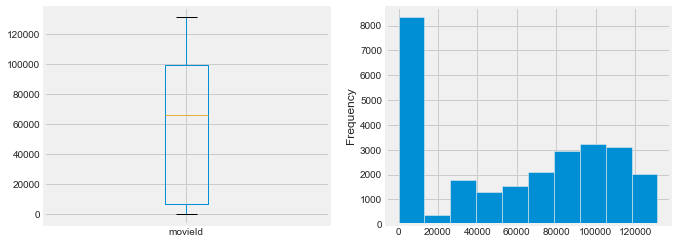

In [16]:
f, ax = plt.subplots(1,2, figsize=(10,4))
avg_rating.movieId.plot(kind='box', ax=ax[0]);
avg_rating.movieId.plot(kind='hist', ax=ax[1]);

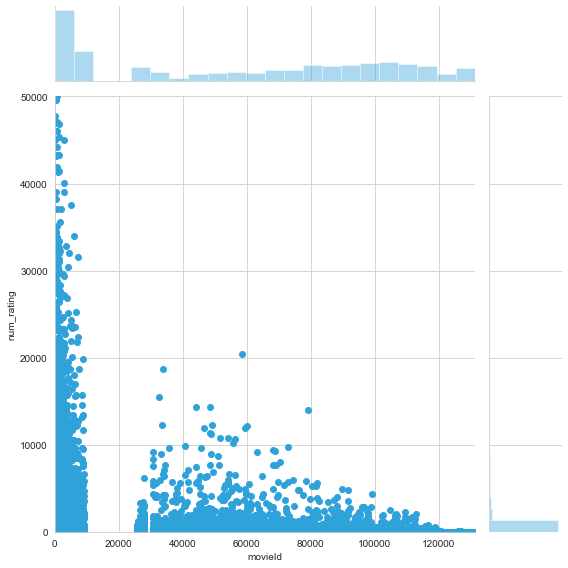

In [125]:
#f, ax = plt.subplots(figsize=(10,6))
#sns.jointplot(x='movieId', y='num_rating', data=avg_rating, kind='kde',height=7)
g = sns.jointplot("movieId", "num_rating", data=avg_rating, height=8, kind='scatter',xlim=(0,131262), ylim=(0,50000))

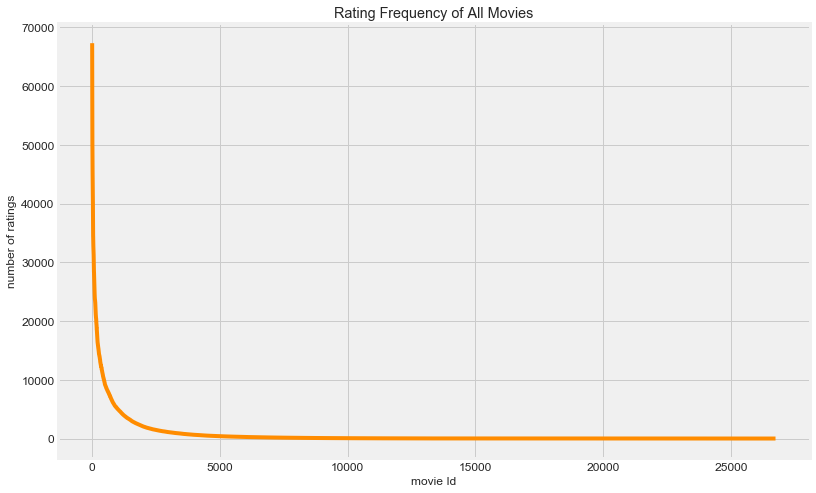

In [138]:
ax = avg_rating['num_rating']\
.sort_values(ascending=False).reset_index(drop=True)\
.plot(figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12,
         c = 'darkorange')
ax.set_xlabel("movie Id");
ax.set_ylabel("number of ratings");

In [13]:
top_rated=avg_rating.sort_values(by=['rating_mean', 'num_rating'], ascending=False).query('num_rating>21')
top_rated

,movieId,title,num_rating,rating_mean
315,318,"Shawshank Redemption, The (1994)",63366,4.446990
843,858,"Godfather, The (1972)",41355,4.364732
49,50,"Usual Suspects, The (1995)",47006,4.334372
523,527,Schindler's List (1993),50054,4.310175
1195,1221,"Godfather: Part II, The (1974)",27398,4.275641
...,...,...,...,...
4679,4775,Glitter (2001),685,1.124088
12003,54290,Bratz: The Movie (2007),180,1.105556
6373,6483,From Justin to Kelly (2003),426,0.973005
8176,8859,SuperBabies: Baby Geniuses 2 (2004),209,0.837321


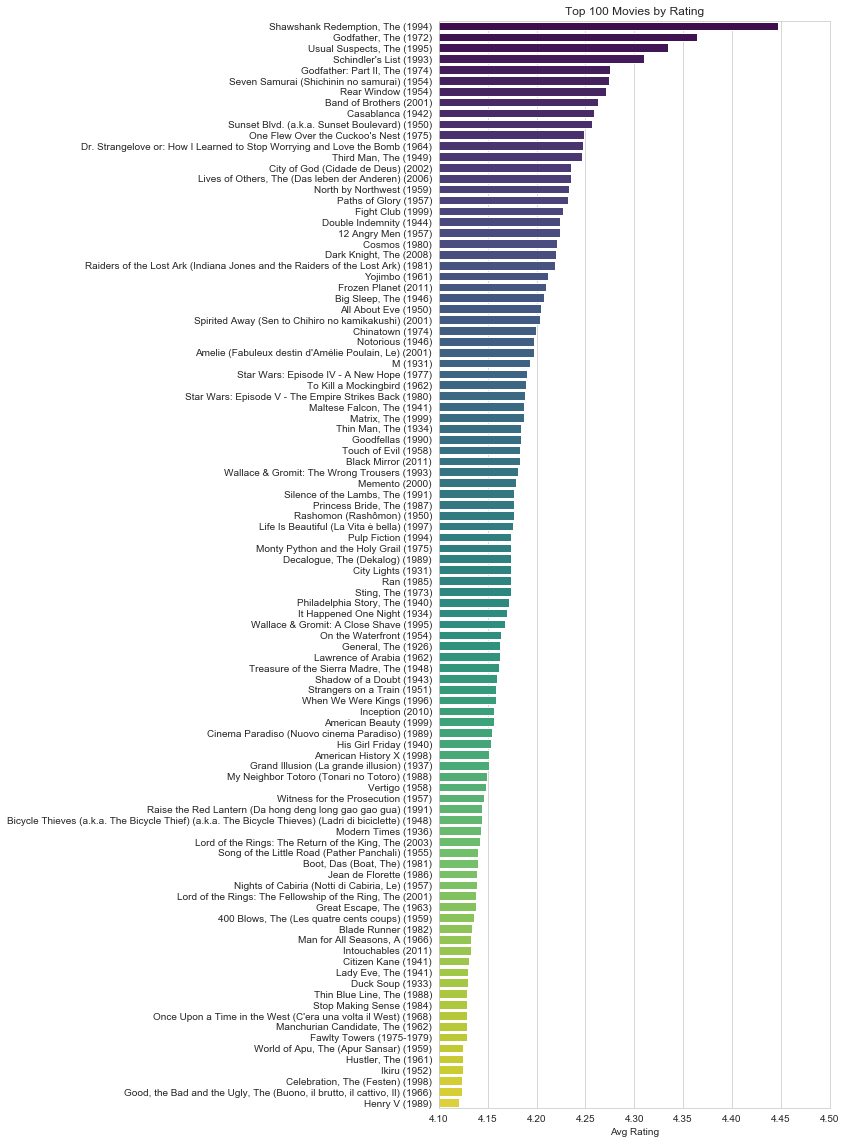

In [142]:
f, ax = plt.subplots(figsize=(7,20))
b = sns.barplot(y='title', x='rating_mean', data=top_rated[:100], palette='viridis' )
b.set(xlim=(4.1,4.5))
ax.set_title('Top 100 Movies by Rating')
ax.set_ylabel('')
ax.set_xlabel('Avg Rating')
plt.show()

In [91]:
top_rated['year'] = top_rated['title'].apply(lambda x: re.findall('\(\d{4}-*\d{0,4}\)', x))
top_rated[top_rated['year'].apply(lambda x: len(x))<1]

,movieId,title,num_rating,rating_mean,year
10584,40697,Babylon 5,56,3.866071,[]


In [93]:
top_rated.loc[10584, 'year'] = [('1994')]

In [94]:
top_rated['year'] = top_rated['year'].apply(lambda x: re.sub(r'\(*\)*', '', x[0]))

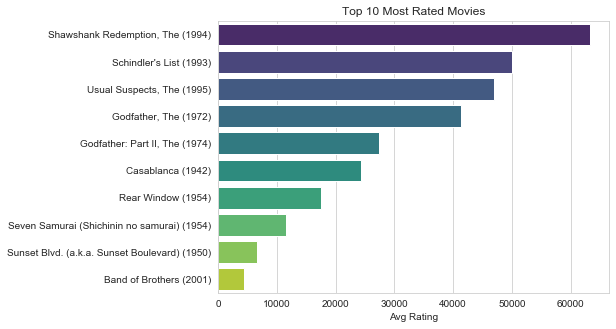

In [83]:
f, ax = plt.subplots(figsize=(7,5))
b = sns.barplot(y='title', x='num_rating', data=top_rated[:10].sort_values(by='num_rating', ascending=False)
                , palette='viridis' )
#b.set(xlim=(4.1,4.5))
ax.set_title('Top 10 Most Rated Movies')
ax.set_ylabel('')
ax.set_xlabel('Avg Rating')
plt.show()

In [ ]:
top_rated.year = top_rated.year.astype(int)

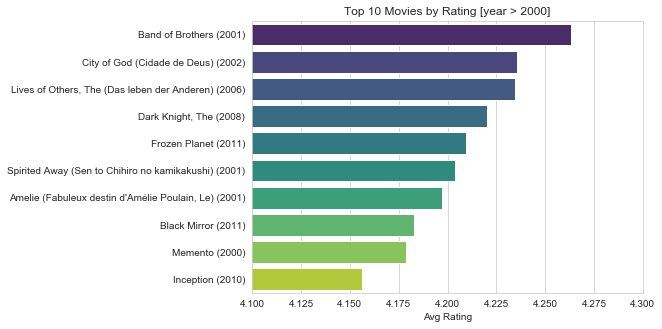

In [130]:
f, ax = plt.subplots(figsize=(7,5))
b = sns.barplot(y='title', x='rating_mean', data=top_rated.query('year>=2000')[:10], palette='viridis' )
b.set(xlim=(4.1,4.3))
ax.set_title('Top 10 Movies by Rating [year > 2000]')
ax.set_ylabel('')
ax.set_xlabel('Avg Rating')
plt.show()

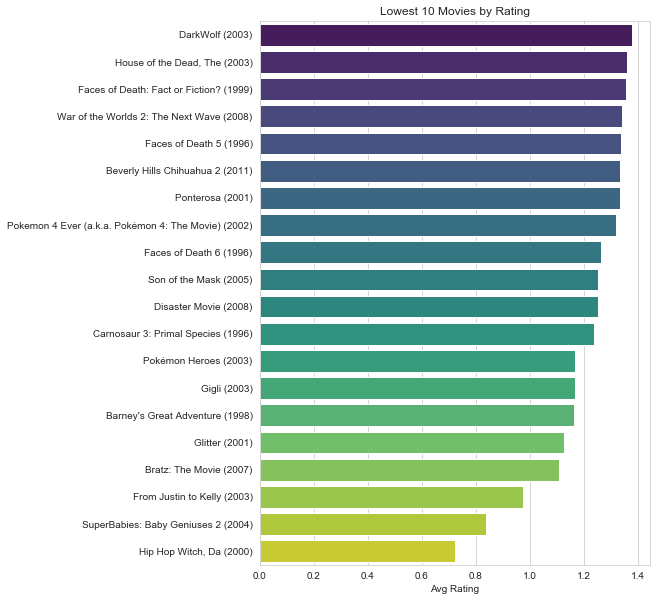

In [137]:
f, ax = plt.subplots(figsize=(7,10))
b = sns.barplot(y='title', x='rating_mean', data=top_rated[-20:], palette='viridis' )
#b.set(xlim=(4.1,4.5))
ax.set_title('Lowest 10 Movies by Rating')
ax.set_ylabel('')
ax.set_xlabel('Avg Rating')
plt.show()

In [143]:
top_rated[-20:]

,movieId,title,num_rating,rating_mean,year
7008,7120,DarkWolf (2003),24,1.375000,2003
6762,6872,"House of the Dead, The (2003)",447,1.356823,2003
5641,5740,Faces of Death: Fact or Fiction? (1999),124,1.354839,1999
13259,64999,War of the Worlds 2: The Next Wave (2008),28,1.339286,2008
5639,5738,Faces of Death 5 (1996),157,1.337580,1996
17508,88301,Beverly Hills Chihuahua 2 (2011),27,1.333333,2011
17625,88764,Ponterosa (2001),24,1.333333,2001
5573,5672,Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (...,472,1.316737,2002
5640,5739,Faces of Death 6 (1996),174,1.261494,1996
9754,31698,Son of the Mask (2005),467,1.252677,2005


In [7]:
user_rating = ratings.groupby('userId')['rating'].agg(['count', 'mean']).sort_values('count', ascending=False).reset_index()
user_rating

,userId,count,mean
0,118205,9254,3.279069
1,8405,7515,3.208317
2,82418,5646,3.516915
3,121535,5520,2.793116
4,125794,5491,3.762976
...,...,...,...
138488,89305,20,3.750000
138489,110463,20,3.750000
138490,96990,20,3.825000
138491,134747,20,2.975000


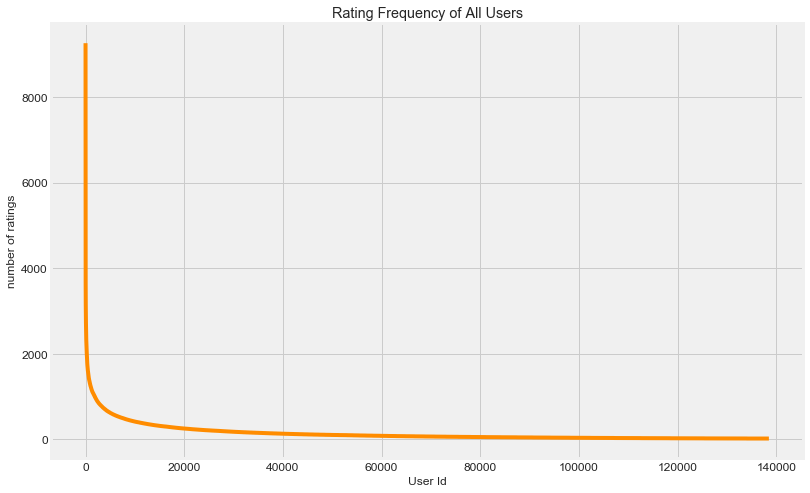

In [11]:
ax = user_rating['count']\
.plot(figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12,
         c = 'darkorange')
ax.set_xlabel("User Id");
ax.set_ylabel("number of ratings");

User and Movie IDs follow the same distribution. lot of users have rated very few movies. 

In [170]:
user_rating['users'] = 'User_'+user_rating['userId']

In [172]:
user_rating

,userId,count,mean,users
0,118205,9254,3.279069,User_118205
1,8405,7515,3.208317,User_8405
2,82418,5646,3.516915,User_82418
3,121535,5520,2.793116,User_121535
4,125794,5491,3.762976,User_125794
...,...,...,...,...
138488,89305,20,3.750000,User_89305
138489,110463,20,3.750000,User_110463
138490,96990,20,3.825000,User_96990
138491,134747,20,2.975000,User_134747


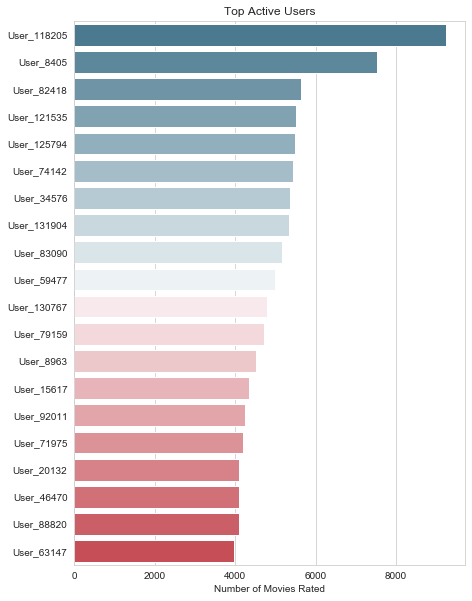

In [192]:

f, ax = plt.subplots(figsize=(7,10))
b = sns.barplot(y='users', x='count', data=user_rating[:20], palette=sns.diverging_palette(230,10,n=20))
#b.set(xlim=(4.1,4.5))
ax.set_title('Top Active Users')
ax.set_ylabel('')
ax.set_xlabel('Number of Movies Rated')
plt.show()

In [7]:
tag

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18
...,...,...,...,...
465559,138446,55999,dragged,2013-01-23 23:29:32
465560,138446,55999,Jason Bateman,2013-01-23 23:29:38
465561,138446,55999,quirky,2013-01-23 23:29:38
465562,138446,55999,sad,2013-01-23 23:29:32


### Benford's Law

In [10]:
import math

range(1, 10)

In [28]:
def benford_law():
    return [math.log10(1+1/float(i)) *100.0 for i in range(1,10)]

In [42]:
movie['first_num'] = movie.movieId.apply(lambda s: str(s)[0])

In [62]:
first_count = movie.first_num.value_counts(normalize=True).mul(100)
ben= benford_law()


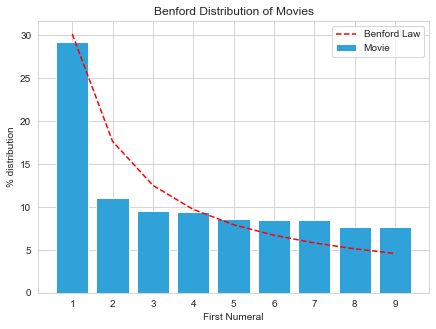

In [71]:
plt.subplots(figsize=(7,5))
plt.bar(x=range(1,10),height =first_count, label='Movie')
plt.plot(range(1,10), ben, ls='--', c='red', label='Benford Law')
plt.legend()
plt.xticks(range(1,10));
plt.ylabel('% distribution');
plt.xlabel('First Numeral');
plt.title('Benford Distribution of Movies');

MovieIds is not the kind of distribution that would follow Benfords Law since it's made up of numbers used as identification (i.e. for movies). Still it does seem to follow the pattern somewhat i.e. distribution follows a decreasing mannger from 1 down to 9. 

## Content Based Filtering

Content based filtering using countvectorizer to encode our genre and tags as movie features. Later we will use cosine similarity to build a movie to movie matrix. It'll be easier to lookup most similar movies against a given title. 

In [57]:
df.keywords = df['genres']+ ', ' + df['tag']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [58]:
df.isnull().sum()/len(df)*100

movieId     0.000000
title       0.000000
genres      0.000000
tags       61.943691
tag        28.348853
dtype: float64

In [59]:
df['tags'] = df['tags'].fillna('')
df['tag'] = df['tag'].fillna('')

In [60]:
df['keywords'] = df['genres']+ ', ' + df['tags'] + ', ' + df['tag']

In [61]:
df.fillna('').isnull().sum()/len(df)*100

movieId     0.0
title       0.0
genres      0.0
tags        0.0
tag         0.0
keywords    0.0
dtype: float64

In [63]:
cv = CountVectorizer()
vect = cv.fit_transform(df['keywords'])

In [65]:
cosine_sim = cosine_similarity(vect, vect)

In [66]:
cosine_sim.shape

(27278, 27278)

cosine_sim is a similarity matrix based on cosine similarity. It has all movies in rows and columns with each value corresponding to similarity between the movies. we can lookup this matrix to find the most similar movies against any title. Below function does exactly that, it looks up a user given 'title' of a movie against the matrix and prints out 'n' number of similar movies.  

In [67]:
def recommendation(title, n=10, cosine_sim=cosine_sim):
    
    mov_idx = df.title 
    # series of movie titles with corresponding indicies. We need to lookup using indicies in our 
    # similarity matrix

    idx = mov_idx[mov_idx == title].index[0] # return the index of our title that will be used to lookup in similarity matrix


    scores_ = pd.Series(cosine_sim[idx]).sort_values(ascending=False) # sorted similar movie vector with similarity scores and indicies
    
    print ('Top {} recommendations for Movie {}:'.format(n,title))
    print('--'*10)
    for i in scores_.index[1:n+1]:
        print(mov_idx[i])

In [346]:
def title_lookup(name, mapper):
    '''
    Title lookup function to easily lookup movie title without having to worry about exact movie name as in our dataframe
    It uses Edit distance (Levenshtein distance ratio) to find close matches to given string on the database.
    
    name = Given name of the title to lookup the database
    mapper = Dictionary of Movies:Index 
    
    It returns matched titles, their index in the database and the corresponding edit distance ratio
    
    '''
    matched = []
    for title, ix in mapper.items():
        ED = fuzz.ratio(title.lower(), name.lower())
        if ED >= 60:
            matched.append((title, ix, ED))
    
    if matched == []:
        return [('No Match Found', 'N/A', 'N/A')]
    else:
        return matched
    
#     mov = df.title.str.lower()
#     if mov.str.contains(title).sum() !=0:
#         idd = mov[mov.str.contains(title)].index[0]
#     else:
#         print ('Title Not Found')
#     return idd

In [230]:
mapper = {mov:i for i,mov in enumerate(list(df['title']))}

In [234]:
m = str(input("Please Enter Movie Name for Recommendations:"))
im, idd, _ = title_lookup(name=m, mapper=mapper)[0]
if im == 'No Match Found':
    print(im)
else:
    recommendation(df.loc[idd,'title'], n=20)

Please Enter Movie Name for Recommendations:matrix,the
Top 20 recommendations for Movie Matrix, The (1999):
--------------------
Matrix Revolutions, The (2003)
Matrix Reloaded, The (2003)
Avalon (2001)
Dark City (1998)
eXistenZ (1999)
Strange Days (1995)
Tron (1982)
Logan's Run (1976)
Visitor to a Museum (Posetitel muzeya) (1989)
Captive Women (1000 Years from Now) (3000 A.D.) (1952)
Thirteenth Floor, The (1999)
Gamer (2009)
Tron: Legacy (2010)
Planet of the Future, The (2010)
Johnny Mnemonic (1995)
Sleep Dealer (2008)
Dawn of the Planet of the Apes (2014)
Autómata (Automata) (2014)
Aeon Flux (2005)
Oblivion (2013)


In [127]:
title_lookup(name=m, mapper=mapper)

[('Iron Man (2008)', 12631, 70)]

In [87]:
name='iron man'

## Collaborative Filtering

### Memory Based CF
#### Item-Item Collabroative Filtering

Main difference when compared to Content Based Filtering is that Collaborative filtering doesn't use item features i.e. Genre, tags etc. It just makes use to ratings provided by the users. 

We will need to make a sparse matrix (since most of the enteries will be blank i.e. not all movies are rated by all users). 

However since the dataset is very large, we will need to filter only the popular movies & most active users, let's see what would be appropriate threshold for that. We will re-created some of the earlier plots

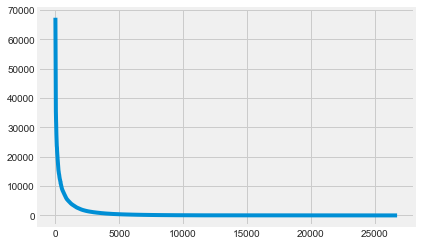

In [254]:
avg_rating['num_rating'].sort_values(ascending=False).reset_index(drop=True).plot();

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

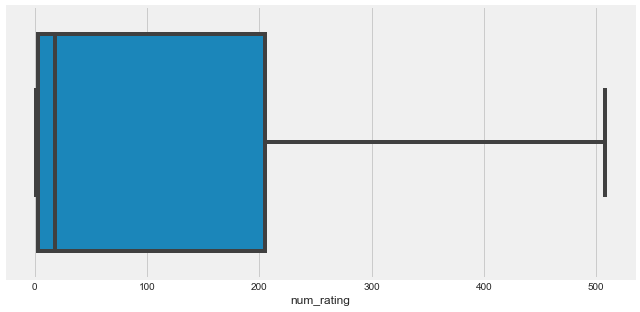

In [227]:
plt.subplots(figsize=(10,5))
sns.boxplot(avg_rating.num_rating,showfliers=False);

In [12]:
pd.DataFrame(avg_rating.num_rating.quantile(np.round(np.arange(1, 0, -0.05),2)))\
.style.apply(lambda x: ["background: Yellow" if v>=47 else "" for v in x], axis = 1)

,num_rating
1.0,67310.000000
0.95,3612.950000
0.9,1305.700000
0.85,632.550000
0.8,346.000000
0.75,205.000000
0.7,123.000000
0.65,74.000000
0.6,47.000000
0.55,29.000000


In [66]:
len(avg_rating[avg_rating.num_rating>=50])#/len(avg_rating)

10524

As seen before, 50% of the movies have ratings less than or equals to 18, if we consider number of rating threshold to be 50 (i.e. movies that have been rated atleast by 50 users), it would roughly cover around 40% of the movies (around 10524 movies out of 26744 rated movies).

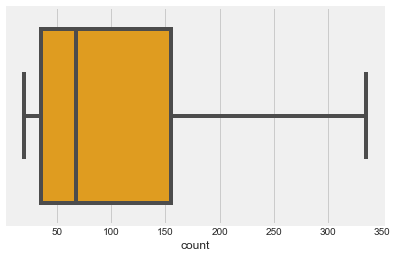

In [46]:
sns.boxplot(user_rating['count'],showfliers=False, color='orange');

In [63]:
# Active users dataframe from earlier
pd.DataFrame(user_rating['count'].quantile(np.round(np.arange(1,0,-0.05),2)))\
.style.apply(lambda x: ['background:Orange' if v>=50 else '' for v in x])

,count
1.0,9254.000000
0.95,520.000000
0.9,334.000000
0.85,246.000000
0.8,193.000000
0.75,155.000000
0.7,127.000000
0.65,108.000000
0.6,93.000000
0.55,79.000000


In [68]:
len(user_rating[user_rating['count']>=50])#/len(user_rating)

85307

50% of the users have rated around 68 or less movies, if we consider number of rating threshold to be 50 (i.e. user that have rated atleast 50 movies), it would roughly cover around 60% of the users (around 85307 users out of 138493 users).

In [8]:
mov_rating = ratings.merge(movie, on='movieId')
mov_rating.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,1996-12-25 15:26:09,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,1996-11-27 08:19:02,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,1996-06-23 20:36:14,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,1996-10-28 13:29:44,Jumanji (1995),Adventure|Children|Fantasy


In [9]:
Threshold = 50

In [10]:
popular_movies = list(avg_rating[avg_rating['num_rating']>=Threshold]['movieId'].values)
active_users = list(user_rating[user_rating['count']>=Threshold]['userId'].values)

In [11]:
data = mov_rating[(mov_rating['movieId'].isin(popular_movies)) & (mov_rating['userId'].isin(active_users))]

In [12]:
matrix = pd.pivot_table(data, values='rating', columns='title', index='userId')

In [12]:
#quick check to find similar movies. 
matrix.corrwith(matrix["Toy Story (1995)"]).sort_values(ascending=False)

title
Toy Story (1995)                                  1.000000
Toy Story 2 (1999)                                0.740931
Paint It Yellow (Rang De Basanti) (2006)          0.687487
Paddington (2014)                                 0.663923
Tangled Ever After (2012)                         0.662054
                                                    ...   
Roommate, The (2011)                             -0.415959
Seventh Heaven (Septième ciel, Le) (1997)        -0.431065
10th & Wolf (2006)                               -0.441907
Poultrygeist: Night of the Chicken Dead (2006)   -0.487570
Company Man (2000)                               -0.595529
Length: 10523, dtype: float64

In [13]:
sparse_matrix = csr_matrix(matrix.fillna(0))

In [311]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(sparse_matrix.T) # Transpose of matrix since we want to make predictions/recommendations against movies. 
# So each row is a movie and columns as users


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [312]:
mapper1 = {movie :i for i, movie in enumerate(matrix.columns)} # mapper to map movie names to index to be used with sparse matrix. 
# Index would remain the same even if movie columns are transposed to indicies since number is the same 

In [353]:
def CFRecommender(model, data, idd):
    
    model.fit(data)
    distance, idx = model.kneighbors(data[idd],n_neighbors=11)
    # this returns the index and distance of 'n' nearest neighbours to the provided index of movie (idd)
    
    id_dist = sorted(list(zip(idx[0].tolist(), distance[0].tolist())), key=lambda x: x[1], reverse=False)[1:]
    
    mapper2 = {i:m for m,i in mapper1.items()}
    
    for j, (i, d) in enumerate(id_dist):
        print('{0}: {1}, with distance of {2}'.format(j+1, mapper2[i], round(d,2)))
        

In [354]:
m = str(input("Please Enter Movie Name for Recommendations:"))
im, idd, _ = title_lookup(name=m, mapper=mapper1)[0]
if im == 'No Match Found':
    print(im)
else:
    print('\n')
    print('Movies similar to {} at index {}'.format(im,idd))
    print('--'*20)
    CFRecommender(model = model_knn, data=sparse_matrix.T, idd=idd)

Please Enter Movie Name for Recommendations:Star Wars: Episode IV


Movies similar to Star Wars: Episode IV - A New Hope (1977) at index 8849
----------------------------------------
1: Star Wars: Episode V - The Empire Strikes Back (1980), with distance of 0.15
2: Star Wars: Episode VI - Return of the Jedi (1983), with distance of 0.17
3: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), with distance of 0.26
4: Back to the Future (1985), with distance of 0.32
5: Indiana Jones and the Last Crusade (1989), with distance of 0.33
6: Terminator, The (1984), with distance of 0.33
7: Matrix, The (1999), with distance of 0.33
8: Alien (1979), with distance of 0.36
9: Terminator 2: Judgment Day (1991), with distance of 0.36
10: Jurassic Park (1993), with distance of 0.37


In [180]:
## Sparsity of the dataset: 

nullcount = matrix.isna().sum().sum()
notnullcount = matrix.notnull().sum().sum()

total_enteries = matrix.shape[0] * matrix.shape[1]

print('Total number of missing enteries in the dataset : {:.2%}'.format(nullcount/total_enteries))

Total number of missing enteries in the dataset : 97.97%


### Model Based Collaborative Filtering 

This will use matrix factorization to represent our movie, user matrix. 

SVD is used to do the matrix factorization

A = U.Σ.V(T)

where
U is left singular orthogonal matrix (eigenvector) 
V(T) is transpose of V, right singular orthogonal matrix (eigenvector)
Σ is a diagonal vector with squareroot of eigenvalues at the diagonal

U represents the feature vectors of users, V represents the feature vectors of the items/movies. 
These are latent features and not entirely evident like for movies it could be how much it's action or comedy etc. 

The eigenvectors of AT.A make up the columns of V , the eigenvectors of A.AT  make up the columns of U.

More at: https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm

However since we a heavily sparse matrix we can't use SVD off the shelf. 

---


#### Algorithm : FunkSVD

So in order to use SVD to make recommendation we need to find the latent feature parameters for both User and Movies Dataset. 

1. We can use our user-movie matrix with non-missing values to train our parameters. So minimize the cost function with regularization applied. 

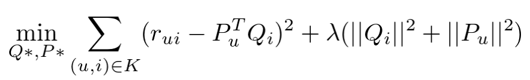

where:
P is latent user feature matrix
Q is latent item feature Matrix
K is the set of user,item pairs
r(u,i) is the rating for item i by user u
λ is the regularization term 

2. To find the latent paramters that minimize the cost function we will use Stchoastic Gradient Descen. Partial derivate of the cost function w.r.t to each latent feature (Q and P) and update the parameters at each step. 
Without regularization it looks like: 





3. Update the parameters simultaneously for the given number of cycles (epochs). 

once we have the learned latent features we can use it to make predictions. 


Reference: 

https://towardsdatascience.com/music-artist-recommender-system-using-stochastic-gradient-descent-machine-learning-from-scratch-5f2f1aae972c

https://www.coursera.org/lecture/matrix-factorization/deriving-funksvd-lyTpD

Simon Funk blog: https://sifter.org/~simon/journal/20061211.html

https://medium.com/datadriveninvestor/how-funk-singular-value-decomposition-algorithm-work-in-recommendation-engines-36f2fbf62cac

http://nicolas-hug.com/blog/matrix_facto_3


In [14]:
matrix_ = matrix.fillna(0).values

In [15]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(matrix_):
    '''
    Takes the user-movie raw matrix. Forms two matrices of same size: train and validation
    For every user that has more than 35 ratings, randomly select 15 of those ratings and
    make them zero in training set and copy original ratings to validation set. 
    '''
    validation = np.zeros(matrix_.shape)
    train = matrix_.copy()
    
    for user in np.arange(matrix_.shape[0]):
        if len(matrix_[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                matrix_[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = matrix_[user, val_ratings]
    return train, validation

In [16]:
train, val = train_test_split(matrix_)

In [23]:
val.shape

(85307, 10523)

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [18]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [19]:
class Recommender:
    
    def __init__(self, n_epochs=100, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
        self.n_epochs = n_epochs
        self.n_latent_features = n_latent_features
        self.lmbda = lmbda
        self.learning_rate = learning_rate

    def predictions(self, P, Q):
        return np.dot(P.T, Q)

    def fit(self, X_train, X_val):
        m, n = X_train.shape

        self.P = 3 * np.random.rand(self.n_latent_features, m)
        self.Q = 3 * np.random.rand(self.n_latent_features, n)

        self.train_error = []
        self.val_error = []

        users, items = X_train.nonzero()

        for epoch in range(self.n_epochs):
            for u, i in zip(users, items):
                error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
                self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
                self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

            train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
            val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
            self.train_error.append(train_rmse)
            self.val_error.append(val_rmse)

        return self

    def predict(self, X_train, user_index):
        y_hat = self.predictions(self.P, self.Q)
        predictions_index = np.where(X_train[user_index, :] == 0)[0]
        return y_hat[user_index, predictions_index].flatten()

In [27]:
recommender = Recommender(n_epochs=15).fit(train, val)
np.savetxt('P_matrix.csv',recommender.P,delimiter = ',')
np.savetxt('Q_matrix.csv',recommender.Q,delimiter = ',')

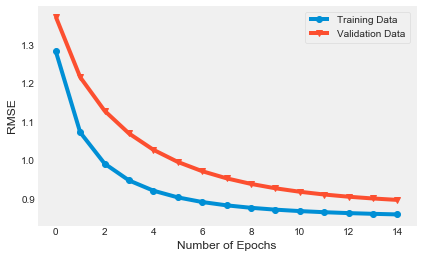

In [28]:
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [29]:
pred = np.dot(recommender.P.T,recommender.Q)

In [156]:
matrix.shape

(85307, 10523)

In [30]:
pred.shape

(85307, 10523)

In [20]:
P = pd.read_csv('P_matrix.csv', header=None)
Q = pd.read_csv('Q_matrix.csv', header=None)
pred = np.dot(P.values.T,Q.values)

In [24]:
pred_mat = pd.DataFrame(data=pred, index=matrix.index , columns=matrix.columns)

In [157]:
# mmax = pred_mat.max().max()
# mmin = pred_mat.min().min()
print('minimum rating is {} and max rating is {} in prediction data set'.format(mmin,mmax))

minimum rating is -1.8912999005085227 and max rating is 9.022478477781952 in prediction data set


Beacuase our P and Q matrices were initialized in such a way their product yields max and min value which doesn't align with our ratings peak values (0 to 5). 
This issue would have resolved itself if we had trained our model for longer, since we only trained for 15 epochs due to very large dataset (over 16milion rating enteries) it's very computationally expensive. 
We will hence define a custom scaler function to align predicted ratings to our scale. This isn't the ideal solution and we should really let it train for longer. 

In [143]:
def scaler(value):
    
    scaled = (5 - 0)/ (mmax-mmin) * (value - mmax) + 5
    return round(scaled,1)

In [152]:
# pred_scaled = pred_mat.apply(lambda x: scaler(x))

lets examine a users rating, pick randing users that has good number of ratings. 

In [154]:
def user_recom(userID, n=10):
    
    userIndex = matrix.index.get_loc(userID)
    tempuser = matrix.iloc[userIndex]
    
    print('Top 10 favourite movies of the User: ', userID)
    print('--'*25)
    print(tempuser[tempuser.notnull()].sort_values(ascending=False).head(10))
    
    #list of not rated movies of the user
    unrated_list = tempuser[tempuser.isna()].index
    
    #predicted ratings for the user
    p_user = pred_scaled.iloc[userIndex]
    print('\n')
    print('Top {} recommendation for the user {} '.format(n,userID))
    print('--'*25)
    print(p_user[p_user.index.isin(unrated_list)].sort_values(ascending=False).head(n))
    

In [159]:
user_rating.head()

,userId,count,mean
0,118205,9254,3.279069
1,8405,7515,3.208317
2,82418,5646,3.516915
3,121535,5520,2.793116
4,125794,5491,3.762976


In [115]:
user_recom(118205,10)

Top 10 favourite movies of the User:  118205
--------------------------------------------------
title
Field of Dreams (1989)                      5.0
Treasure of the Sierra Madre, The (1948)    5.0
Dark Knight Rises, The (2012)               5.0
Shane (1953)                                5.0
Citizen Kane (1941)                         5.0
Ox-Bow Incident, The (1943)                 5.0
Beautiful Mind, A (2001)                    5.0
American in Paris, An (1951)                5.0
All Quiet on the Western Front (1930)       5.0
Singin' in the Rain (1952)                  5.0
Name: 118205, dtype: float64


Top 10 recommendation for the user 118205 
--------------------------------------------------
title
Human Condition III, The (Ningen no joken III) (1961)      4.087467
Human Condition II, The (Ningen no joken II) (1959)        4.073127
Song of the Little Road (Pather Panchali) (1955)           4.047816
Bill Hicks: Revelations (1993)                             4.034019
Ordet (Word, Th

In [163]:
user_rating.sample()['userId'].values[0]

1899

In [164]:
user_recom(1899,10)

Top 10 favourite movies of the User:  1899
--------------------------------------------------
title
Woodstock (1970)               5.0
Secretary (2002)               5.0
Being There (1979)             5.0
Bend It Like Beckham (2002)    5.0
Caine Mutiny, The (1954)       5.0
Casablanca (1942)              5.0
Citizen Kane (1941)            5.0
Dangerous Liaisons (1988)      5.0
Dead Poets Society (1989)      5.0
High Noon (1952)               5.0
Name: 1899, dtype: float64


Top 10 recommendation for the user 1899 
--------------------------------------------------
title
Kid Brother, The (1927)                     3.3
Quai des Orfèvres (Jenny Lamour) (1947)     3.2
Westerner, The (1940)                       3.2
Pervert's Guide to Ideology, The (2012)     3.2
Right at Your Door (2006)                   3.1
Method, The (Método, El) (2005)             3.1
Pusher II: With Blood on My Hands (2004)    3.1
Way Out West (1937)                         3.1
Company You Keep, The (2012)           

To find similar movies to each other we can use correlation matric (pearson's correlation) against our predicted dataset. 

In [36]:
pred_mat.corrwith(pred_mat["Toy Story (1995)"]).sort_values(ascending=False)

title
Toy Story (1995)                                 1.000000
Departures (Okuribito) (2008)                    0.999987
Stealing Home (1988)                             0.999984
Career Girls (1997)                              0.999984
Blame It on Rio (1984)                           0.999981
                                                   ...   
Sharknado (2013)                                 0.155335
Sprung (1997)                                    0.154551
Beast of Yucca Flats, The (1961)                 0.143288
Death Ship (1980)                                0.142618
Revenge of the Nerds IV: Nerds in Love (1994)    0.141389
Length: 10523, dtype: float64